In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors as mcolors
from scgenome import cncluster
from scdna_replication_tools.plot_utils import get_acc_cmap, get_phase_cmap, get_methods_cmap, get_clone_cmap, plot_colorbar, make_color_mat_float, plot_clustered_cell_cn_matrix

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True

despine_offset = 10
despine_trim = True

### Load and preprocess data showing the true and PERT + Kronos inferred replication states for simulated dataset P5.8

In [3]:
dataset = 'P5.8'
df_kronos = pd.read_csv('scdna_replication_paper/analysis/simulation/{}/s_phase_cells_kronos_inferred.tsv'.format(dataset), sep='\t')
df_pert = pd.read_csv('scdna_replication_paper/analysis/simulation/{}/s_phase_cells_pyro_composite_inferred.tsv'.format(dataset), sep='\t')
df = pd.merge(df_kronos, df_pert)
df_pert.shape, df_kronos.shape, df.shape

((1282400, 58), (1282400, 54), (1282400, 60))

In [4]:
df.columns

Index(['cell_id', 'chr', 'start', 'end', 'reads', 'gc', 'map', 'copy', 'state',
       'multiplier', 'autocorrelation_hmmcopy', 'mean_hmmcopy_reads_per_bin',
       'std_hmmcopy_reads_per_bin', 'total_mapped_reads_hmmcopy',
       'total_halfiness', 'scaled_halfiness', 'breakpoints', 'mean_copy',
       'mcf7_rt', 'bg02es_rt', 'bj_rt', 'gm06990_rt', 'gm12801_rt',
       'gm12812_rt', 'gm12813_rt', 'gm12878_rt', 'helas3_rt', 'hepg2_rt',
       'huvec_rt', 'imr90_rt', 'k562_rt', 'sknsh_rt', 'nhek_rt', 'bin_size',
       'clone_id', 'clone_cn_state', 'true_G1_state', 'library_id',
       'true_reads_norm', 'true_reads_raw', 'true_rep', 'true_p_rep', 'true_t',
       'observed_cn_state', 'true_cell_frac_rep', 'madn', 'lrs',
       'corrected_madn', 'corrected_breakpoints', 'laks_is_s_phase',
       'laks_is_s_phase_prob', 'laks_phase', 'rt_state', 'frac_rt',
       'assigned_clone_id', 'model_cn_state', 'model_rep_state', 'model_tau',
       'model_u', 'model_rho'],
      dtype='object')

In [5]:
def compute_cell_frac(cn, frac_rt_col='cell_frac_rep', rep_state_col='model_rep_state'):
    ''' Compute the fraction of replicated bins for all cells in `cn` '''
    for cell_id, cell_cn in cn.groupby('cell_id'):
        temp_rep = cell_cn[rep_state_col].values
        temp_frac = sum(temp_rep) / len(temp_rep)
        cn.loc[cell_cn.index, frac_rt_col] = temp_frac
    return cn

In [6]:
# set chr column to category
df.chr = df.chr.astype('str').astype('category')

pert_rep_col = 'model_rep_state'
kronos_rep_col = 'rt_state'
true_rep_col = 'true_rep'
pert_rt_diff_col = 'pert_rt_state_diff'
kronos_rt_diff_col = 'kronos_rt_state_diff'
# 1 is false positive, 0 is accurate, -1 is false negative
df[pert_rt_diff_col] = df[pert_rep_col] - df[true_rep_col]
df[kronos_rt_diff_col] = df[kronos_rep_col] - df[true_rep_col]

# compute fraction of replicated bins per cells from the pert output
pert_frac_rt_col = 'model_cell_frac_rep'
kronos_frac_rt_col = 'frac_rt'
true_frac_rt_col = 'true_cell_frac_rep'
if pert_frac_rt_col not in df.columns:
    df = compute_cell_frac(df, frac_rt_col=pert_frac_rt_col, rep_state_col='model_rep_state')

In [7]:
def plot_true_vs_inferred_heatmaps(
    df,
    ax_clone,
    ax_time,
    ax_hmmcopy,
    ax_pert,
    ax_kronos,
    true_frac_col='true_cell_frac_rep',
    hmmcopy_state='state',
    pert_rt_diff_col='pert_rt_state_diff',
    kronos_rt_diff_col='kronos_rt_state_diff',
    chrom_labels_to_remove=[]
):
    """ 
    Plot heatmaps of hmmcopy states, Kronos, and PERT replication state errors.
    All rows of each heatmap are sorted by clone id and the true time in S-phase.
    """
    # create mapping of clones to cluster ids
    cluster_col = 'cluster_id'
    clone_col = 'clone_id'
    clone_dict = dict([(y,x+1) for x,y in enumerate(sorted(df[clone_col].unique()))])
    df[cluster_col] = df[clone_col]
    df = df.replace({cluster_col: clone_dict})

    # note which columns to sort by
    secondary_sort_column = true_frac_col

    # create a color map for the accuracies
    acc_cmap = get_acc_cmap()

    # compute accuracy of inferred replication states for each method
    pert_rep_accuracy = 1.0 - (sum(abs(df[pert_rt_diff_col])) / df.shape[0])
    kronos_rep_accuracy = 1.0 - (sum(abs(df[kronos_rt_diff_col])) / df.shape[0])

    # left: hmmcopy CN state
    plot_data0 = plot_clustered_cell_cn_matrix(
        ax_hmmcopy, df, hmmcopy_state, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, 
        chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )
    ax_hmmcopy.set_title('HMMcopy state')

    # middle: kronos replication state accuracy 
    plot_data1 = plot_clustered_cell_cn_matrix(
        ax_kronos, df, kronos_rt_diff_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column, 
        cmap=acc_cmap, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )
    ax_kronos.set_title('Kronos replication accuracy = {}'.format(round(kronos_rep_accuracy, 3)))

    # right PERT replication state accuracy
    plot_data2 = plot_clustered_cell_cn_matrix(
        ax_pert, df, pert_rt_diff_col, cluster_field_name=cluster_col, secondary_field_name=secondary_sort_column,
        cmap=acc_cmap, chrom_boundary_width=0.5, chrom_labels_to_remove=chrom_labels_to_remove
    )
    ax_pert.set_title('PERT replication accuracy = {}'.format(round(pert_rep_accuracy, 3)))

    # hide the y-ticks and labels for all heatmaps
    for ax in [ax_clone, ax_time, ax_hmmcopy, ax_kronos, ax_pert]:
        ax.set_yticks([])
        ax.set_yticklabels([])
    
    if len(clone_dict) > 1:
        # annotate the clones for G1-phase cells
        cell_ids = plot_data0.columns.get_level_values(0).values
        cluster_ids0 = plot_data0.columns.get_level_values(1).values
        clone_cmap = get_clone_cmap()
        # use mcolors to change every element in the dict to rgba
        for key in clone_cmap.keys():
            clone_cmap[key] = mcolors.to_rgba(clone_cmap[key])
        color_mat0, color_map0 = cncluster.get_cluster_colors(cluster_ids0, color_map=clone_cmap, return_map=True)

        # get list of color pigments in the same order as clone_dict
        colors_used0 = []
        for c in color_mat0:
            if c not in colors_used0:
                colors_used0.append(c)

        # match clone IDs to color pigments
        clones_to_colors0 = {}
        for i, key in enumerate(clone_dict.keys()):
            clones_to_colors0[key] = colors_used0[i]

        # get array of secondary_sort_column values that that match the cell_id order
        condensed_cn = df[['cell_id', secondary_sort_column]].drop_duplicates()
        secondary_array = []
        for cell in cell_ids:
            s = condensed_cn[condensed_cn['cell_id'] == cell][secondary_sort_column].values[0]
            secondary_array.append(s)

        # make color mat according to secondary array
        secondary_color_mat, secondary_to_colors = make_color_mat_float(secondary_array, 'Blues')

        # plot a color bar corresponding to clone ID
        plot_colorbar(ax_clone, color_mat0)

        # plot a color bar corresponding to secondary_sort_column
        plot_colorbar(ax_time, secondary_color_mat)
            
    # add 'chromosome' x-axis label to the heatmaps
    for ax in [ax_hmmcopy, ax_kronos, ax_pert]:
        ax.set_xlabel('chromosome')
    
    ax_clone.set_ylabel('{} simulated S-phase cells'.format(len(df.cell_id.unique())))

    # add x-axis ticklabels to the ax_clone and ax_time colorsbars
    ax_clone.set_xticks([0.0])
    ax_clone.set_xticklabels(['clone'], rotation=90)
    ax_time.set_xticks([0.0])
    ax_time.set_xticklabels(['time'], rotation=90)


### Create functions for plotting the true vs inferred fraction of replicated bins per cell

In [8]:
def plot_swarmplot_with_lines(df, df_frac, ax, x='source', y='frac_rt', left_set_col='true_cell_frac_rep', right_set_col='frac_rt'):
    # swarmplot with lines connecting point pairs
    sns.swarmplot(data=df_frac, x=x, y=y, ax=ax, size=2, hue=x, palette=get_methods_cmap())
    # Now connect the dots
    # Find idx0 and idx1 by inspecting the elements return from ax.get_children()
    # ... or find a way to automate it
    idx0 = 0
    idx1 = 1
    locs1 = ax.get_children()[idx0].get_offsets()
    locs2 = ax.get_children()[idx1].get_offsets()

    # before plotting, we need to sort so that the data points
    # correspond to each other as they did in "set1" and "set2"
    set1 = df[left_set_col].values
    set2 = df[right_set_col].values
    sort_idxs1 = np.argsort(set1)
    sort_idxs2 = np.argsort(set2)

    # revert "ascending sort" through sort_idxs2.argsort(),
    # and then sort into order corresponding with set1
    locs2_sorted = locs2[sort_idxs2.argsort()][sort_idxs1]

    for i in range(locs1.shape[0]):
        _x = [locs1[i, 0], locs2_sorted[i, 0]]
        _y = [locs1[i, 1], locs2_sorted[i, 1]]
        ax.plot(_x, _y, color="black", alpha=0.05)


def plot_frac_rt_distributions(df, ax_kronos, ax_pert, kronos_frac_rt_col='frac_rt', pert_frac_rt_col='model_cell_frac_rep', true_frac_rt_col='true_cell_frac_rep'):
    df = df[['cell_id', true_frac_rt_col, kronos_frac_rt_col, pert_frac_rt_col]].drop_duplicates().reset_index(drop=True)
    
    df_frac_kronos = df.rename(columns={true_frac_rt_col: 'true', kronos_frac_rt_col: 'Kronos'})
    df_frac_kronos.drop(columns=pert_frac_rt_col, inplace=True)
    df_frac_kronos = df_frac_kronos.melt(id_vars='cell_id', var_name='source', value_name='frac_rt')

    df_frac_pert = df.rename(columns={true_frac_rt_col: 'true', pert_frac_rt_col: 'PERT'})
    df_frac_pert.drop(columns=kronos_frac_rt_col, inplace=True)
    df_frac_pert = df_frac_pert.melt(id_vars='cell_id', var_name='source', value_name='frac_rt')


    # plot the swarmplots
    plot_swarmplot_with_lines(df, df_frac_kronos, ax_kronos, x='source', y='frac_rt', left_set_col=true_frac_rt_col, right_set_col=kronos_frac_rt_col)
    plot_swarmplot_with_lines(df, df_frac_pert, ax_pert, x='source', y='frac_rt', left_set_col=true_frac_rt_col, right_set_col=pert_frac_rt_col)

    # format the axes labels and titles
    for ax in [ax_kronos, ax_pert]:
        ax.set_title('S-phase times')
        ax.set_ylim(0, 1)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_xlabel('')
        ax.legend().remove()
        sns.despine(ax=ax, offset=despine_offset, trim=despine_trim)
    
    # remove the left spine from ax_pert
    sns.despine(ax=ax_pert, left=True)
    ax_pert.set_yticks([])
    ax_pert.set_ylabel('')
    ax_pert.set_yticklabels('')
    
    ax_kronos.set_ylabel('fraction of replicated bins')
    ax_pert.set_ylabel('')


### Plot a jointplot of the true vs inferred S-phase time for all simulated datasets

In [9]:
df_phase = pd.read_csv('scdna_replication_paper/analysis/simulation/all/phase_accuracies.tsv', sep='\t')

df_phase['PERT_phase'] = df_phase['PERT_phase'].astype(str)
df_phase['true_phase'] = df_phase['true_phase'].astype(str)
df_phase['laks_phase'] = df_phase['laks_phase'].astype(str)
df_phase['cell_id'] = df_phase['cell_id'].astype(str)

# rename the lambda column to lambd to avoid conflict with python keyword
df_phase.rename(columns={'lambda': 'lamb'}, inplace=True)

# melt `PERT_phase_acc` and `laks_phase_acc` into a single column `phase_acc`
# and 'PERT_phase' and 'laks_phase' into a single column `pred_phase`
# where the method is noted in a new column `method`
df_phase = pd.melt(df_phase, 
    id_vars=[col for col in df_phase.columns if not col.endswith('_phase_acc')],
    value_vars=['PERT_phase_acc', 'laks_phase_acc'], var_name='method', value_name='phase_acc')

# rename the method column to remove the '_phase_acc' suffix
df_phase['method'] = df_phase['method'].str.replace('_phase_acc', '')

# create a new column named 'predicted_phase' that is the same as 'PERT_phase' if 'method' is 'PERT', 'laks_phase' if the method is 'laks'
df_phase['predicted_phase'] = np.where(df_phase['method'] == 'PERT', df_phase['PERT_phase'], df_phase['laks_phase'])

print(df_phase[['cell_id', 'method', 'true_phase', 'predicted_phase']].head())

# create a new column named 'phase_class' which says whether the 
# given prediction is a true positive, false positive, true negative, or false negative
df_phase['phase_class'] = 'None'
for i, row in df_phase.iterrows():
    if row['predicted_phase'] == row['true_phase'] and row['true_phase'] == 'S':
        df_phase.at[i, 'phase_class'] = 'TP'
    elif row['predicted_phase'] == row['true_phase'] and row['true_phase'] == 'G1/2':
        df_phase.at[i, 'phase_class'] = 'TN'
    elif row['predicted_phase'] != row['true_phase'] and row['true_phase'] == 'S':
        df_phase.at[i, 'phase_class'] = 'FN'
    elif row['predicted_phase'] != row['true_phase'] and row['true_phase'] == 'G1/2':
        df_phase.at[i, 'phase_class'] = 'FP'

print(df_phase[['cell_id', 'method', 'true_phase', 'predicted_phase', 'phase_class']])
print(df_phase.phase_class.value_counts())

# drop the pert_phase and laks_phase columns
df_phase.drop(columns=['PERT_phase', 'laks_phase'], inplace=True)

# fill missing true_cell_frac_rep values with 0.0 as these are G1/2 cells with no replicated bins
df_phase['true_cell_frac_rep'].fillna(0.0, inplace=True)

# rename 'LowQual' entries in the 'predicted_phase' column to 'LQ'
df_phase['predicted_phase'] = df_phase['predicted_phase'].str.replace('LowQual', 'LQ')

df_phase.head()

      cell_id method true_phase predicted_phase
0    cell_S_0   PERT          S               S
1    cell_S_1   PERT          S               S
2   cell_S_10   PERT          S               S
3  cell_S_100   PERT          S               S
4  cell_S_101   PERT          S               S
           cell_id method true_phase predicted_phase phase_class
0         cell_S_0   PERT          S               S          TP
1         cell_S_1   PERT          S               S          TP
2        cell_S_10   PERT          S               S          TP
3       cell_S_100   PERT          S               S          TP
4       cell_S_101   PERT          S               S          TP
...            ...    ...        ...             ...         ...
307195   cell_G_79   laks       G1/2            G1/2          TN
307196   cell_G_81   laks       G1/2            G1/2          TN
307197   cell_G_88   laks       G1/2            G1/2          TN
307198   cell_G_95   laks       G1/2            G1/2          

,cell_id,true_phase,true_cell_frac_rep,cell_frac_rep,datatag,dataset,alpha,lamb,beta0,beta1,cell_cna_rate,num_clones,method,phase_acc,predicted_phase,phase_class
0,cell_S_0,S,0.083287,0.078291,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
1,cell_S_1,S,0.100715,0.094510,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
2,cell_S_10,S,0.176848,0.163755,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
3,cell_S_100,S,0.810677,0.804117,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP
4,cell_S_101,S,0.594019,0.570805,D1,D1.0,10.0,0.75,1.2,0.0,0.0,1,PERT,0.99875,S,TP


In [10]:
def plot_time_jointplot(df, ax_scatter, ax_hist, pt_size=5):
    ''' Plot a jointplot of the PERT and true fraction of replicated bins per cell. Use the phase class (TP, FP, TN, FN) as the hue. '''
    # subset to just the rows with method=='PERT'
    df = df.query('method=="PERT"').query('lamb==0.75')
    # phase_class_pal = {'TP': 'green', 'TN': 'blue', 'FP': 'red', 'FN': 'orange'}
    pal = get_phase_cmap()
    # plot a scatterplot of the true and inferred fraction of replicated bins per cell
    sns.scatterplot(data=df, x='true_cell_frac_rep', y='cell_frac_rep', hue='true_phase', palette=pal, ax=ax_scatter, s=pt_size, alpha=0.2, rasterized=True)
    ax_scatter.set_xlabel('true time')
    ax_scatter.set_ylabel('PERT time')
    ax_scatter.legend(title='true phase')

    # plot a histogram of the inferred fraction of replicated bins per cell along the y-axis
    sns.histplot(data=df, y='cell_frac_rep', hue='true_phase', palette=pal, ax=ax_hist, kde=False, bins=20, common_norm=False)
    ax_hist.set_ylabel('')
    ax_hist.legend().set_visible(False)

    # despine the scatterplot and histogram
    sns.despine(ax=ax_scatter, offset=despine_offset, trim=despine_trim)
    # sns.despine(ax=axes[1], offset=despine_offset, trim=despine_trim)

    # remove all the ticks, tick-labels, and spines from the histogram
    for spine in ax_hist.spines.values():
        spine.set_visible(False)
    ax_hist.set_xticks([])
    ax_hist.set_yticks([])
    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('')

No handles with labels found to put in legend.


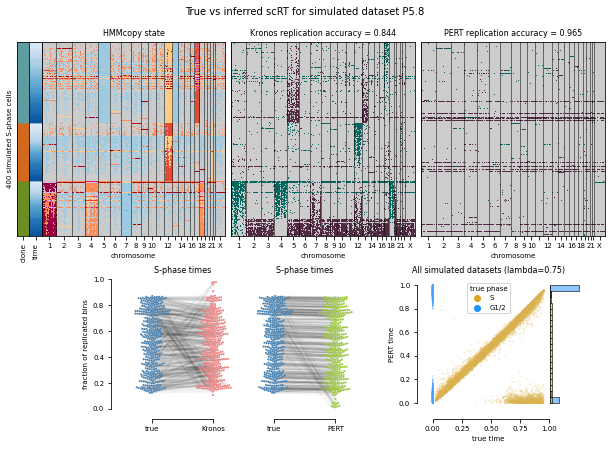

In [12]:
# create a large 8.5 x 11 figure and manually add all the subplots with custom positioning
# since I'm adding labels the figure will be slightly larger than the specified size,
# thus I need to divide the width and height by a multiplicative factor to get the correct size
mult_factor = 1.0
fig = plt.figure(figsize=(8.5/mult_factor, 6/mult_factor))

# create subplots for showing the hmmcopy state, Kronos replication accuracy, and PERT replication accuracy
# with colorbars on the left to denote clone ID and S-time
ax_clone = fig.add_axes([0.03, 0.45, 0.02, 0.45])
ax_time = fig.add_axes([0.05, 0.45, 0.02, 0.45])
ax_hmmcopy = fig.add_axes([0.07, 0.45, 0.3, 0.45])
ax_kronos = fig.add_axes([0.38, 0.45, 0.3, 0.45])
ax_pert = fig.add_axes([0.69, 0.45, 0.3, 0.45])

# add two subplots underneath the heatmaps to show the distribution of true and inferred S times for each method
ax_kronos_time = fig.add_axes([0.2, 0.05, 0.2, 0.3])
ax_pert_time = fig.add_axes([0.4, 0.05, 0.2, 0.3])

# add subplots for showing a jointplot between true and inferred S times
ax_scatter = fig.add_axes([0.7, 0.05, 0.2, 0.3])
ax_hist = fig.add_axes([0.9, 0.05, 0.05, 0.3])


chrom_labels_to_remove = ['11', '13', '15', '17', '19', '20', '22']

# plot the heatmaps in the top row
plot_true_vs_inferred_heatmaps(
    df,
    ax_clone,
    ax_time,
    ax_hmmcopy,
    ax_pert,
    ax_kronos,
    true_frac_col=true_frac_rt_col,
    hmmcopy_state='state',
    pert_rt_diff_col=pert_rt_diff_col,
    kronos_rt_diff_col=kronos_rt_diff_col,
    chrom_labels_to_remove=chrom_labels_to_remove
)


plot_time_jointplot(df_phase, ax_scatter, ax_hist, pt_size=3)
ax_scatter.set_title('All simulated datasets (lambda=0.75)')


# plot the swarmplots of true vs inferred S-phase times in the bottom row
plot_frac_rt_distributions(df, ax_kronos_time, ax_pert_time, kronos_frac_rt_col=kronos_frac_rt_col, pert_frac_rt_col=pert_frac_rt_col, true_frac_rt_col=true_frac_rt_col)

# draw a dashed lines around the boundaries of the entire figure to know where to crop
# ax_bottom = fig.add_axes([0, 0, 1, 0.01])
# ax_top = fig.add_axes([0, 0.99, 1, 0.01])
# ax_left = fig.add_axes([0, 0, 0.01, 1])
# ax_right = fig.add_axes([0.99, 0, 0.01, 1])
# for ax in [ax_bottom, ax_top, ax_left, ax_right]:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

fig.suptitle('True vs inferred scRT for simulated dataset {}'.format(dataset))

fig.savefig('scdna_replication_paper/manuscript/supplementary_figs/figS3.pdf', dpi=300, bbox_inches='tight')

plt.show()